In [2]:
#!/usr/bin/env python3
# Two-way ANOVA analysis for genomic oxidation data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import statsmodels.api as sm
import os
import re
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
import traceback
import polars as pl

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

In [19]:
def preprocess_data(file_path):

    print(f"Reading data from {file_path}...")
    
    # Extract bin size from file path
    bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    print(f"Detected bin size: {bin_size}")
    
    # Read the CSV file
    df = pl.read_csv(file_path)
    
    # Create FeatureID by combining Bin, Strand, and Chromosome
    df['FeatureID'] = df['Bin'].cast(pl.String) + '_' + df['Strand'] + df['Chromosome'].cast(pl.String)
    
    # Handle potential duplicates by grouping
    df['Group'] = df.groupby(['Sample', 'FeatureID']).cumcount().cast(pl.String)
    
    # Show sample of the processed data
    print("Sample of the processed dataframe:")
    print(df[['Sample', 'Bin', 'Strand', 'FeatureID', 'Group', 'Median_Normalized_Damage']].head(5))
    
    # Create pivot table: samples as rows, features as columns
    pivot_df = df.pivot_table(
        index='Sample', 
        columns='FeatureID', 
        values='Median_Normalized_Damage',
        aggfunc='mean'
    )
    
    # Extract bin IDs (these will be the column names in the pivot table)
    bin_ids = pivot_df.columns.tolist()
    
    # Extract metadata from sample names
    metadata_df = pl.DataFrame(index=pivot_df.index)
    
    # Extract group (treatment) and time point from sample names
    metadata_df['treatment'] = metadata_df.index.map(lambda x: re.search(r'(CRS|Ctrl)', x).group(1) if re.search(r'(CRS|Ctrl)', x) else "Unknown")
    metadata_df['timepoint'] = metadata_df.index.map(lambda x: re.search(r'(evening|morning)', x).group(1) if re.search(r'(evening|morning)', x) else "Unknown")
    
    # Reset index to make Sample a standard column
    metadata_df = metadata_df.reset_index().rename(columns={'index': 'Sample'})
    
    print(f"Created pivot table with {pivot_df.shape[0]} samples and {pivot_df.shape[1]} genomic features")
    print(f"Extracted metadata with factors: treatment ({metadata_df['treatment'].unique()}) and timepoint ({metadata_df['timepoint'].unique()})")
    print(metadata_df.head(5))
    
    return pivot_df, bin_ids, metadata_df

In [4]:
def perform_two_way_anova(bin_data, factor1_name, factor2_name):
    try:
        # Create the formula for the model
        formula = f"measurement ~ C({factor1_name}) + C({factor2_name}) + C({factor1_name}):C({factor2_name})"
        
        # Fit the model (using Type III SS)
        model = ols(formula, data=bin_data).fit()
        
        # Get ANOVA table
        anova_table = sm.stats.anova_lm(model, typ=3)
        
        # Extract results
        results = {
            'factor1_pvalue': anova_table.loc[f'C({factor1_name})', 'PR(>F)'],
            'factor2_pvalue': anova_table.loc[f'C({factor2_name})', 'PR(>F)'],
            'interaction_pvalue': anova_table.loc[f'C({factor1_name}):C({factor2_name})', 'PR(>F)'],
            'factor1_Fvalue': anova_table.loc[f'C({factor1_name})', 'F'],
            'factor2_Fvalue': anova_table.loc[f'C({factor2_name})', 'F'],
            'interaction_Fvalue': anova_table.loc[f'C({factor1_name}):C({factor2_name})', 'F']
        }
        
        return results
    
    except Exception as e:
        # Return NaN values if error occurs
        return {
            'factor1_pvalue': np.nan,
            'factor2_pvalue': np.nan,
            'interaction_pvalue': np.nan,
            'factor1_Fvalue': np.nan,
            'factor2_Fvalue': np.nan,
            'interaction_Fvalue': np.nan
        }

In [5]:
def process_bin(args):

    bin_idx, bin_id, pivot_df, metadata_df, factor1_name, factor2_name = args
    
    # Extract measurements for this bin
    bin_values = pivot_df.iloc[:, bin_idx].values
    
    # Create DataFrame with measurements and factors
    df = pl.DataFrame({
        'measurement': bin_values,
        'Sample': pivot_df.index.tolist()
    })

    
    # Merge with metadata to get the factors
    df = pl.merge(df, metadata_df, on='Sample')
    
    # Perform ANOVA
    result = perform_two_way_anova(df, factor1_name, factor2_name)
    result['bin_id'] = bin_id
    
    return result

In [6]:
def create_batches(items, batch_size):
    """Split a list of items into batches of specified size"""
    for i in range(0, len(items), batch_size):
        yield items[i:i + batch_size]
        

In [7]:
def process_batch(batch_args):
    """Process a batch of bins"""
    batch_bins_with_idx, pivot_data, meta_data, f1_name, f2_name = batch_args
    batch_results = []
    
    for bin_idx, bin_id in batch_bins_with_idx:
        # Call the original process_bin function with the correct bin_idx
        result = process_bin((bin_idx, bin_id, pivot_data, meta_data, f1_name, f2_name))
        batch_results.append(result)
        
    return batch_results


In [8]:
def analyze_genomic_bins(pivot_df, bin_ids, metadata_df, factor1_name='treatment', factor2_name='timepoint', 
                       figures_dir=None, data_dir=None,
                       n_cores=64, batch_size=1000):

    bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    output_prefix = "anova_" + bin_size 

    # Create output directories if specified
    if figures_dir is not None:
        os.makedirs(figures_dir, exist_ok=True)
    
    if data_dir is not None:
        os.makedirs(data_dir, exist_ok=True)
    
    # Determine number of cores for parallel processing
    if n_cores is None:
        n_cores = max(1, mp.cpu_count() - 1)  # Leave one core free
    
    total_bins = len(bin_ids)
    print(f"Processing {total_bins} bins using {n_cores} cores with batch size {batch_size}...")
    
    # Create a list of (bin_idx, bin_id) pairs
    bin_idx_id_pairs = list(enumerate(bin_ids))
    
    # Group these pairs into batches
    bin_batches_with_idx = list(create_batches(bin_idx_id_pairs, batch_size))
    
    # Prepare batch arguments
    batch_args_list = [(batch, pivot_df, metadata_df, factor1_name, factor2_name) 
                      for batch in bin_batches_with_idx]
    
    # Results container
    all_results = []
    
    # Set up parallel processing with chunked work
    with mp.Pool(n_cores) as pool:
        # Use imap to maintain order of batches
        batch_iterator = pool.imap(process_batch, batch_args_list)
        
        # Process batches with progress bar
        with tqdm(total=total_bins) as pbar:
            for batch_results in batch_iterator:
                all_results.extend(batch_results)
                pbar.update(len(batch_results))
    
    # Convert results to DataFrame
    results_df = pl.DataFrame(all_results)


    
    # No need to sort since we maintained the original order with imap
    
    # Apply multiple testing correction
    for col in ['factor1_pvalue', 'factor2_pvalue', 'interaction_pvalue']:
        # Benjamini-Hochberg FDR correction
        mask = ~np.isnan(results_df[col])
        corrected = np.full(len(results_df), np.nan)
        
        if mask.sum() > 0:
            corrected[mask] = multipletests(results_df.loc[mask, col], method='fdr_bh')[1]
            
        results_df[f'{col}_adj'] = corrected
        
        # Add significance flag (True/False)
        results_df[f'{col.replace("pvalue", "significant")}'] = results_df[f'{col}_adj'] < 0.05
    
    # Prepare output path
    if data_dir is not None:
        results_path = os.path.join(data_dir, f"{output_prefix}_results.csv")
    else:
        results_path = f"{output_prefix}_results.csv"

    print("results_df")
    print (results_df.head(5))
    
    # Write results to file
    results_df.to_csv(results_path, index=False)
    
    print(f"Analysis complete. Found:")
    print(f"  - {results_df['factor1_significant'].sum()} bins significant for {factor1_name}")
    print(f"  - {results_df['factor2_significant'].sum()} bins significant for {factor2_name}")
    print(f"  - {results_df['interaction_significant'].sum()} bins significant for interaction")
    print(f"  - Results CSV saved to: {results_path}")
    
    return results_df

In [9]:
def manhattan_plot(results_df, factor1_name, factor2_name, plots_dir):

    print("Starting manhattan plot..")
    
    # 1. Manhattan-like plot of p-values
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor1_pvalue']), 
               alpha=0.5, s=10, label=factor1_name)
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor2_pvalue']), 
               alpha=0.5, s=10, label=factor2_name)
    plt.scatter(range(len(results_df)), -np.log10(results_df['interaction_pvalue']), 
               alpha=0.5, s=10, label='Interaction')
    
    # Add significance thresholds
    plt.axhline(-np.log10(0.05), linestyle='--', color='red', label='p=0.05')
    plt.axhline(-np.log10(0.05/len(results_df)), linestyle='--', color='blue', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title('Manhattan Plot of Two-way ANOVA p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot.png", dpi=300)

    print ("Done with manhattan plot")
    

In [10]:
def manhattan_plot_seperate(results_df, factor1_name, factor2_name, plots_dir):
    print("Starting manhattan plots..")
    
    # Common significance thresholds
    significance_05 = -np.log10(0.05)
    bonferroni = -np.log10(0.05/len(results_df))
    
    # 1. Factor 1 Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor1_pvalue']), 
               alpha=0.8, s=10, color='blue')
    
    # Add significance thresholds
    plt.axhline(significance_05, linestyle='--', color='red', label='p=0.05')
    plt.axhline(bonferroni, linestyle='--', color='purple', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Manhattan Plot of {factor1_name} p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot_{factor1_name.replace(' ', '_').lower()}.png", dpi=300)
    
    # 2. Factor 2 Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor2_pvalue']), 
               alpha=0.8, s=10, color='green')
    
    # Add significance thresholds
    plt.axhline(significance_05, linestyle='--', color='red', label='p=0.05')
    plt.axhline(bonferroni, linestyle='--', color='purple', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Manhattan Plot of {factor2_name} p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot_{factor2_name.replace(' ', '_').lower()}.png", dpi=300)
    
    # 3. Interaction Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['interaction_pvalue']), 
               alpha=0.8, s=10, color='orange')
    
    # Add significance thresholds
    plt.axhline(significance_05, linestyle='--', color='red', label='p=0.05')
    plt.axhline(bonferroni, linestyle='--', color='purple', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Manhattan Plot of Interaction p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot_interaction.png", dpi=300)
    
    print("Done with manhattan plots")

In [11]:
def volcano_plot(results_df, factor1_name, factor2_name, plots_dir):

    print ("Starting volcano plot")
    
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_Fvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_Fvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_Fvalue', 'interaction_significant')
    ]
    
    for name, pval_col, fval_col, sig_col in factor_cols:
        plt.figure(figsize=(8, 6))
        
        # Create a mask for non-NaN values
        mask = ~np.isnan(results_df[pval_col]) & ~np.isnan(results_df[fval_col])
        
        # Create a scatter plot with color indicating significance
        plt.scatter(
            results_df.loc[mask, fval_col],
            -np.log10(results_df.loc[mask, pval_col]),
            c=results_df.loc[mask, sig_col].map({True: 'red', False: 'black'}),
            alpha=0.5,
            s=15
        )
        
        plt.axhline(-np.log10(0.05), linestyle='--', color='red', label='p=0.05')
        plt.xlabel('F value (effect size)')
        plt.ylabel('-log10(p-value)')
        plt.title(f'Volcano Plot: {name}')
        plt.tight_layout()
        
        plt.savefig(f"{plots_dir}/volcano_{name.lower().replace(' ', '_')}.png", dpi=300)

    print ("Done with volcano plot")
    

In [12]:
def pvalue_distribution(results_df, factor1_name, factor2_name, plots_dir):
    
    print ("Starting pvalue distribution plot")
    
    plt.figure(figsize=(10, 6))
    
    # Create histograms for each factor
    bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
    
    for i, (name, col) in enumerate(zip(
        [factor1_name, factor2_name, 'Interaction'],
        ['factor1_pvalue', 'factor2_pvalue', 'interaction_pvalue']
    )):
        # Skip NaN values
        p_values = results_df[col].dropna()
        if len(p_values) > 0:
            plt.hist(p_values, bins=bins, alpha=0.5, label=name)
    
    plt.xlabel('p-value')
    plt.ylabel('Count')
    plt.title('Distribution of p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/pvalue_distribution.png", dpi=300)

    print ("Done with pvalue distribution plot")


In [13]:
def significance_summary(file_path, results_df, factor1_name, factor2_name, data_dir):

    print ("Starting significance summary..")
    
    bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    output_prefix = "anova_" + bin_size 
    
    # Create a DataFrame with all combinations of significance
    sig_df = pl.DataFrame({
        factor1_name: results_df['factor1_significant'],
        factor2_name: results_df['factor2_significant'],
        'Interaction': results_df['interaction_significant']
    })
    
    # Create a summary table
    summary = pl.DataFrame(columns=['Category', 'Count'])

    total_bins = len(results_df)
    
    # Add total
    summary = pl.concat([summary, pl.DataFrame({'Category': ['Total bins'], 'Count': [total_bins]})])
    
    # Add individual significances
    for factor in [factor1_name, factor2_name, 'Interaction']:
        count = sig_df[factor].sum()
        summary = pl.concat([summary, pl.DataFrame({'Category': [f'Significant for {factor}'], 'Count': [count]})])

    
    # Add overlap counts
    for i, f1 in enumerate([factor1_name, factor2_name, 'Interaction']):
        for f2 in [factor1_name, factor2_name, 'Interaction'][i+1:]:
            count = (sig_df[f1] & sig_df[f2]).sum()
            summary = pl.concat([summary, pl.DataFrame({'Category': [f'Significant for both {f1} and {f2}'], 'Count': [count]})])
    
    # Add triple overlap
    count = (sig_df[factor1_name] & sig_df[factor2_name] & sig_df['Interaction']).sum()
    summary = pl.concat([summary, pl.DataFrame({'Category': ['Significant for all three factors'], 'Count': [count]})])

    bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    # Save summary in current directory
    summary.to_csv(f"{data_dir}/{output_prefix}_significance_summary.csv", index=False)

    print ("Done with significance summary")
    

In [14]:
def prepare_significant_bins_data(results_df, factor1_name, factor2_name, max_bins=10, file_path=None, table_path=None, data_dir=None):
    
    import pandas as pd
    import polars as pl
    import numpy as np
    import re
    
    if file_path:
        bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
        output_prefix = "anova_" + bin_size
    else:
        output_prefix = "anova"
    
    print(f"Preparing top significant bins data...")
    
    # Load the chromosome naming table
    chromosomes_name_table = pl.read_csv(table_path, sep='\t')

    # Filter chromosomes_name_table
    chromosomes = ['chr' + str(i) for i in np.arange(1, 20, 1)] + ["chrX", "chrY"]
    chromosomes_name_table = chromosomes_name_table[chromosomes_name_table["UCSC style name"].isin(chromosomes)]
    chromosomes_name_table = chromosomes_name_table.loc[:, ["RefSeq seq accession", "UCSC style name"]]

    # Create a dictionary for faster lookups
    chrom_dict = dict(zip(chromosomes_name_table["RefSeq seq accession"], chromosomes_name_table["UCSC style name"]))

    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', bin_id)
        if match:
            index = float(match.group(1))
            strand = match.group(2)
            ref_seq = match.group(3)
            
            if ref_seq in chrom_dict:
                # Convert index to integer
                return f"{chrom_dict[ref_seq]}{strand}{int(index)}"
        return None
    
    # For each factor, get the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
    
    # Dictionary to store DataFrames with top bins
    top_bins_dict = {}
    for name, pval_col, sig_col in factor_cols:
        # Get significant bins
        sig_bins = results_df[results_df[sig_col] == True].copy()
        
        if len(sig_bins) == 0:
            print(f"No significant bins found for {name}")
            continue
            
        # Sort by p-value
        sig_bins = sig_bins.sort_values(pval_col)
        
        # Take top bins
        top_bins = sig_bins.head(min(max_bins, len(sig_bins))).copy()
        
        # Add UCSC style ID column
        top_bins['ucsc_style_id'] = top_bins['bin_id'].apply(create_ucsc_style_id)
        
        top_bins_dict[f"{name.lower()}_top_bins"] = top_bins
        
        # Save the CSV with the new column if data_dir is provided
        if data_dir:
            top_bins.to_csv(f"{data_dir}/{output_prefix}_{name.lower()}_top_bins.csv", index=False)
    
    # NEW CODE: Create a fourth file with the most significant factor for all significant bins
    print("Creating combined significant bins file with most significant factor...")
    
    # Step 1: Identify all bins that are significant for any factor
    all_sig_bins = results_df[
        (results_df['factor1_significant'] == True) | 
        (results_df['factor2_significant'] == True) | 
        (results_df['interaction_significant'] == True)
    ].copy()
    
    if len(all_sig_bins) == 0:
        print("No significant bins found for any factor")
        return top_bins_dict
    
    # Step 2: Add a column to identify the most significant factor for each bin
    def get_most_significant_factor(row):
        # Create a dictionary of adjusted p-values (lower is more significant)
        p_values = {
            factor1_name: row['factor1_pvalue_adj'] if row['factor1_significant'] else float('inf'),
            factor2_name: row['factor2_pvalue_adj'] if row['factor2_significant'] else float('inf'),
            'Interaction': row['interaction_pvalue_adj'] if row['interaction_significant'] else float('inf')
        }
        
        # Get the factor with the lowest adjusted p-value
        most_sig_factor = min(p_values, key=p_values.get)
        
        # If no factor is significant, return None
        if p_values[most_sig_factor] == float('inf'):
            return None
        
        return most_sig_factor
    
    # Add columns for most significant factor and its p-value
    all_sig_bins['most_significant_factor'] = all_sig_bins.apply(get_most_significant_factor, axis=1)
    
    # Add F-values for each factor and the maximum F-value
    all_sig_bins['max_f_value'] = all_sig_bins[['factor1_Fvalue', 'factor2_Fvalue', 'interaction_Fvalue']].max(axis=1)
    
    # Add a column indicating which factors are significant for each bin
    def get_significant_factors(row):
        sig_factors = []
        if row['factor1_significant']:
            sig_factors.append(factor1_name)
        if row['factor2_significant']:
            sig_factors.append(factor2_name)
        if row['interaction_significant']:
            sig_factors.append('Interaction')
        return ';'.join(sig_factors)
    
    all_sig_bins['significant_factors'] = all_sig_bins.apply(get_significant_factors, axis=1)
    
    # Add UCSC style ID column
    all_sig_bins['ucsc_style_id'] = all_sig_bins['bin_id'].apply(create_ucsc_style_id)
    
    # Sort by the maximum F-value (descending)
    all_sig_bins = all_sig_bins.sort_values('max_f_value', ascending=False)
    
    # Store in dictionary
    top_bins_dict['all_significant_bins'] = all_sig_bins
    
    # Save the CSV if data_dir is provided
    if data_dir:
        all_sig_bins.to_csv(f"{data_dir}/{output_prefix}_all_significant_bins.csv", index=False)
    
    return top_bins_dict


In [16]:
def plot_significant_bins(pivot_df, metadata_df, top_bins_dict, factor1_name, factor2_name, bin_plots_dir=None):
  
    print(f"Plotting top significant bins...")
    
    # For each factor, plot the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
    
    for name, pval_col, sig_col in factor_cols:
        dict_key = f"{name.lower()}_top_bins"
        
        if dict_key not in top_bins_dict:
            print(f"No significant bins found for {name}")
            continue
            
        top_bins = top_bins_dict[dict_key]
        
        # Plot each top bin
        for i, row in enumerate(top_bins.itertuples()):
            try:
                # Get the bin ID
                bin_id = row.bin_id
                
                # Get the UCSC style ID
                display_id = row.ucsc_style_id if hasattr(row, 'ucsc_style_id') and row.ucsc_style_id else bin_id
                
                # Check if bin exists in pivot table
                if bin_id not in pivot_df.columns:
                    print(f"Warning: Bin {bin_id} not found in data")
                    continue
                
                # Create a DataFrame for this bin
                bin_data = pl.DataFrame({
                    'Sample': pivot_df.index,
                    'measurement': pivot_df[bin_id].values
                })
                
                # Merge with metadata
                bin_data = pl.merge(bin_data, metadata_df, on='Sample')
                
                # Create the plot
                plt.figure(figsize=(10, 6))
                
                # Use seaborn for better visualization
                ax = sns.pointplot(data=bin_data, x=factor1_name, y='measurement', 
                                  hue=factor2_name, dodge=True, errorbar=('se', 1), 
                                  capsize=0.2)
                
                # Add title and p-values
                plt.title(f"Bin: {display_id}")  # Use UCSC style ID here
                plt.suptitle(
                    f"{factor1_name} p = {getattr(row, f'factor1_pvalue'):.3e}, "
                    f"{factor2_name} p = {getattr(row, f'factor2_pvalue'):.3e}, "
                    f"Interaction p = {getattr(row, f'interaction_pvalue'):.3e}",
                    y=0.92, fontsize=9
                )
                
                plt.ylabel('Oxidation Level')
                plt.tight_layout()
                
                # Save the figure if bin_plots_dir is provided
                if bin_plots_dir:
                    # Use the UCSC style ID in the filename
                    save_id = display_id.replace(':', '_')
                    output_file = f"{bin_plots_dir}/{name.lower()}_top{i+1}_{save_id}"
                    plt.savefig(f"{output_file}.png", dpi=300)
                plt.close()
                
            except Exception as e:
                print(f"Error plotting bin {bin_id}: {str(e)}")
    
    if bin_plots_dir:
        print(f"Bin plots complete. All plots saved to {bin_plots_dir}")

In [17]:
def create_heatmap(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict=None, max_bins=50, heatmap_dir=None):
    
    print(f"Creating heatmaps of top significant bins...")
    
    # For each factor, create a heatmap of the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
  
    for name, pval_col, sig_col in factor_cols:
        # Get the top bins from the dictionary
        dict_key = f"{name.lower()}_top_bins"
        
        if dict_key not in top_bins_dict:
            print(f"No significant bins found for {name}, skipping heatmap.")
            continue
            
        top_bins = top_bins_dict[dict_key]
        
        # Get the bin IDs
        bin_ids = top_bins['bin_id'].tolist()
        
        # Get the UCSC style IDs for labeling
        if 'ucsc_style_id' in top_bins.columns:
            # Create a mapping from bin_id to ucsc_style_id
            id_mapping = dict(zip(top_bins['bin_id'], top_bins['ucsc_style_id']))
        else:
            id_mapping = {bin_id: bin_id for bin_id in bin_ids}
        
        # Filter pivot table to only include these bins
        # Check if all bin IDs exist in the pivot table
        existing_bins = [b for b in bin_ids if b in pivot_df.columns]
        
        if len(existing_bins) < 2:
            print(f"Not enough valid bins for {name} to create a heatmap, need at least 2.")
            continue
            
        bins_pivot = pivot_df[existing_bins]
        
        
        # Add the factors to the index
        heatmap_df = bins_pivot.copy()
        heatmap_df[factor1_name] = metadata_df.set_index('Sample')[factor1_name]
        heatmap_df[factor2_name] = metadata_df.set_index('Sample')[factor2_name]
        
        # Sort by factors
        heatmap_df = heatmap_df.sort_values([factor1_name, factor2_name])
        
        # Extract the factors for the row colors
        row_colors = pl.DataFrame({
            factor1_name: heatmap_df[factor1_name],
            factor2_name: heatmap_df[factor2_name]
        })
        
        # Remove the factors from the dataframe before plotting
        heatmap_data = heatmap_df.drop([factor1_name, factor2_name], axis=1)
        
        # Rename columns from bin_id to ucsc_style_id for better readability
        heatmap_data.columns = [id_mapping.get(col, col) for col in heatmap_data.columns]
        
        # Check if we have enough data to cluster
        if heatmap_data.shape[1] < 2 or heatmap_data.shape[0] < 2:
            print(f"Not enough data to create a heatmap for {name}.")
            continue
            
        # Create color map for factors
        factor1_values = row_colors[factor1_name].unique()
        factor2_values = row_colors[factor2_name].unique()
        
        factor1_cmap = dict(zip(factor1_values, sns.color_palette("Set1", len(factor1_values))))
        factor2_cmap = dict(zip(factor2_values, sns.color_palette("Set2", len(factor2_values))))
        
        # Apply color maps
        row_colors_mapped = pl.DataFrame({
            factor1_name: row_colors[factor1_name].map(factor1_cmap),
            factor2_name: row_colors[factor2_name].map(factor2_cmap)
        })


        # Create the heatmap
        plt.figure(figsize=(max(10, len(existing_bins) * 0.4), max(8, len(heatmap_data) * 0.4)))

            
        # Use clustermap for hierarchical clustering
        g = sns.clustermap(
            heatmap_data,
            cmap="viridis",
            #z_score=0, # uncomment this for normalization
            row_colors=row_colors_mapped,
            col_cluster=True,
            row_cluster=False,
            xticklabels=True,
            yticklabels=False,
            figsize=(max(10, len(existing_bins) * 0.4), max(8, len(heatmap_data) * 0.4))
        )
            
        # Add title
        plt.suptitle(f"Heatmap of top {len(existing_bins)} bins significant for {name}", y=1.02)
            
        # Create legends for factors
        for factor, cmap, pos in zip(
            [factor1_name, factor2_name],
            [factor1_cmap, factor2_cmap],
            [1.01, 1.01 + 0.05 * len(factor1_values)]
        ):
            for label, color in cmap.items():
                g.ax_row_dendrogram.bar(0, 0, color=color, label=f"{factor}: {label}", linewidth=0)
            g.ax_row_dendrogram.legend(loc="center left", ncol=1, bbox_to_anchor=(1, pos))
            
        # Save the figure in images/anova_results
        plt.savefig(f"{heatmap_dir}/{name.lower()}_heatmap.png", dpi=300, bbox_inches='tight')
    
    print(f"Heatmaps complete. All heatmaps saved to {heatmap_dir}")

In [20]:
# Load and preprocess data

file_path = '../data_normalized/cleaned_Normalized_1000.csv' #CHANGE PATH


pivot_df, bin_ids, metadata_df = preprocess_data(file_path)

# View the first few rows of processed data
display(pivot_df.head())
display(metadata_df.head())


Reading data from ../data_normalized/cleaned_Normalized_1000.csv...
Detected bin size: 1000


TypeError: DataFrame object does not support `Series` assignment by index

Use `DataFrame.with_columns`.

In [20]:
# Run the analysis

factor1_name = 'treatment'  # CRS vs Ctrl
factor2_name = 'timepoint'  # morning vs evening
figures_dir = 'images/anova_results' #PATH TO SAVE FIGURES 
data_dir = 'data_anova' #PATH TO SAVE CSV FILES

batch_size = 10000  # BATCH SIZE DEPENDING ON DATASET SIZE. BIGGER DATASET SHOULD BE PROCESSED WITH BIGGER BATCH SIZE, BUT A TOO BIG BATCH SIZE CAN OVERLOAD MEMORY
n_cores = 64 # NUMBER OF CORES AVAILABLE

results_df = analyze_genomic_bins(pivot_df, bin_ids, metadata_df,
                                factor1_name, factor2_name, 
                                figures_dir, data_dir, n_cores, batch_size)

display(results_df.head())
print(f"Significant for {factor1_name}: {results_df['factor1_significant'].sum()}")
print(f"Significant for {factor2_name}: {results_df['factor2_significant'].sum()}")
print(f"Significant for interaction: {results_df['interaction_significant'].sum()}")


Processing 5300115 bins using 64 cores with batch size 10000...


100%|██████████| 5300115/5300115 [33:38<00:00, 2625.91it/s]


results_df
   factor1_pvalue  factor2_pvalue  interaction_pvalue  factor1_Fvalue  \
0        0.388146        0.992342            0.590193        0.787012   
1        0.209009        0.427919            0.171171        1.713598   
2        0.845940        0.950397            0.797888        0.038998   
3        0.202635        0.434886            0.230830        1.765042   
4        0.190679        0.911905            0.332493        1.867330   

   factor2_Fvalue  interaction_Fvalue                   bin_id  \
0        0.000095            0.302044   1000000.0_+NC_000087.8   
1        0.661647            2.052855   1000000.0_-NC_000087.8   
2        0.003993            0.067801  10000000.0_+NC_000067.7   
3        0.641543            1.551615  10000000.0_+NC_000068.8   
4        0.012634            0.998730  10000000.0_+NC_000069.7   

   factor1_pvalue_adj  factor1_significant  factor2_pvalue_adj  \
0            0.865057                False            1.000000   
1            0.822443

,factor1_pvalue,factor2_pvalue,interaction_pvalue,factor1_Fvalue,factor2_Fvalue,interaction_Fvalue,bin_id,factor1_pvalue_adj,factor1_significant,factor2_pvalue_adj,factor2_significant,interaction_pvalue_adj,interaction_significant
0,0.388146,0.992342,0.590193,0.787012,0.000095,0.302044,1000000.0_+NC_000087.8,0.865057,False,1.000000,False,0.968593,False
1,0.209009,0.427919,0.171171,1.713598,0.661647,2.052855,1000000.0_-NC_000087.8,0.822443,False,0.988836,False,0.959878,False
2,0.845940,0.950397,0.797888,0.038998,0.003993,0.067801,10000000.0_+NC_000067.7,0.985835,False,1.000000,False,0.985357,False
3,0.202635,0.434886,0.230830,1.765042,0.641543,1.551615,10000000.0_+NC_000068.8,0.821915,False,0.989057,False,0.959878,False
4,0.190679,0.911905,0.332493,1.867330,0.012634,0.998730,10000000.0_+NC_000069.7,0.821211,False,1.000000,False,0.959878,False


Significant for treatment: 75
Significant for timepoint: 66
Significant for interaction: 11


Starting general visualisations..
Starting manhattan plots..
Done with manhattan plots
Starting significance summary..
Done with significance summary
Done with general visualisations


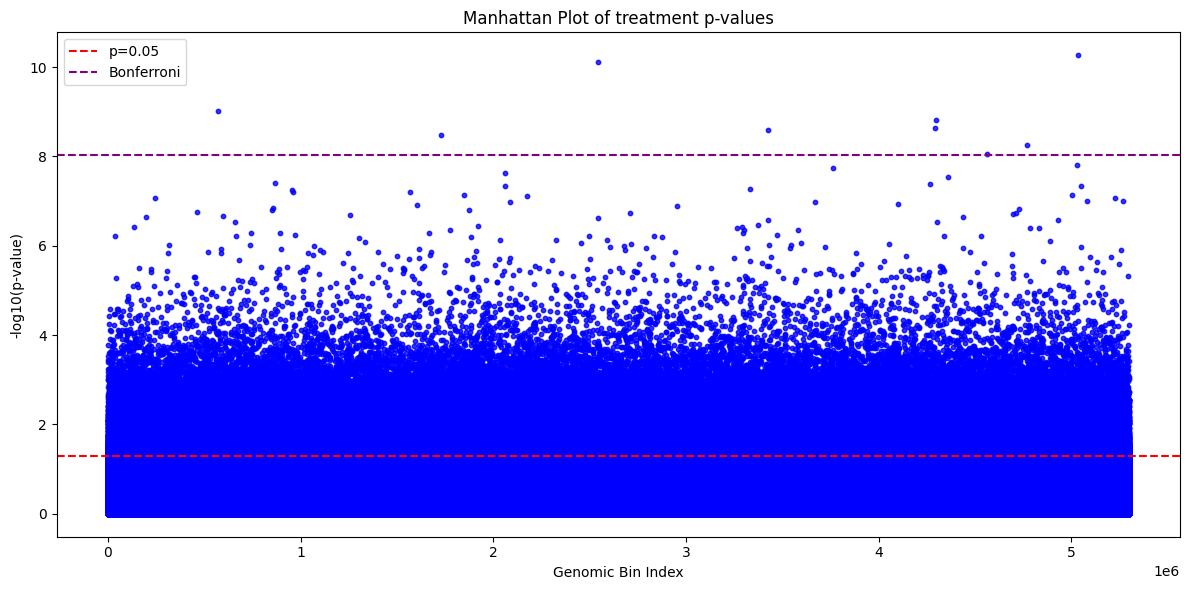

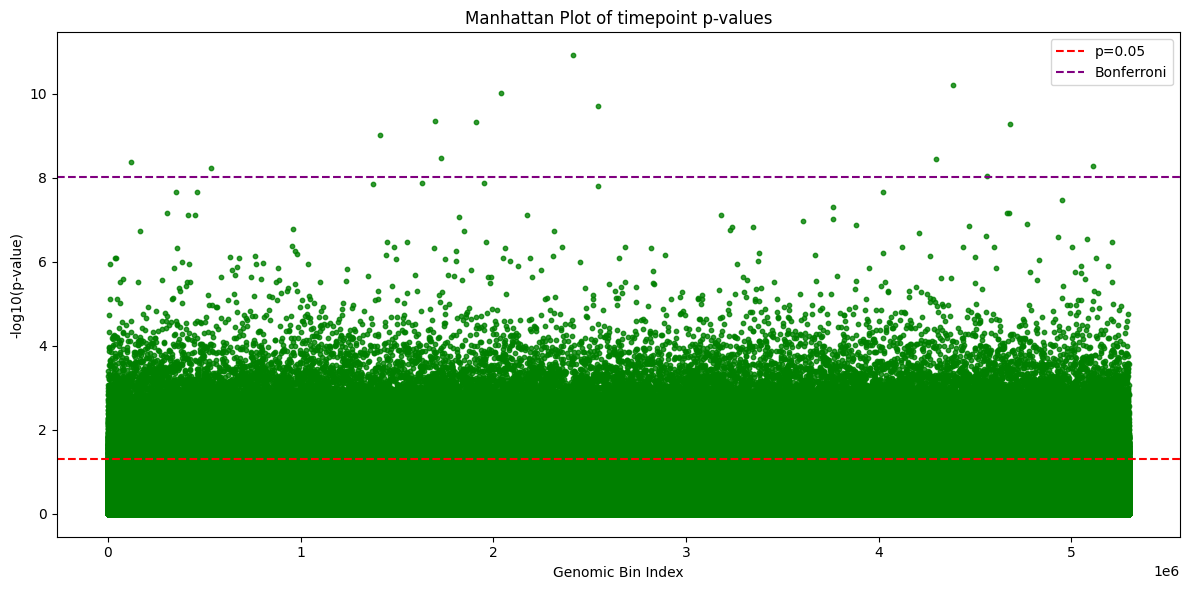

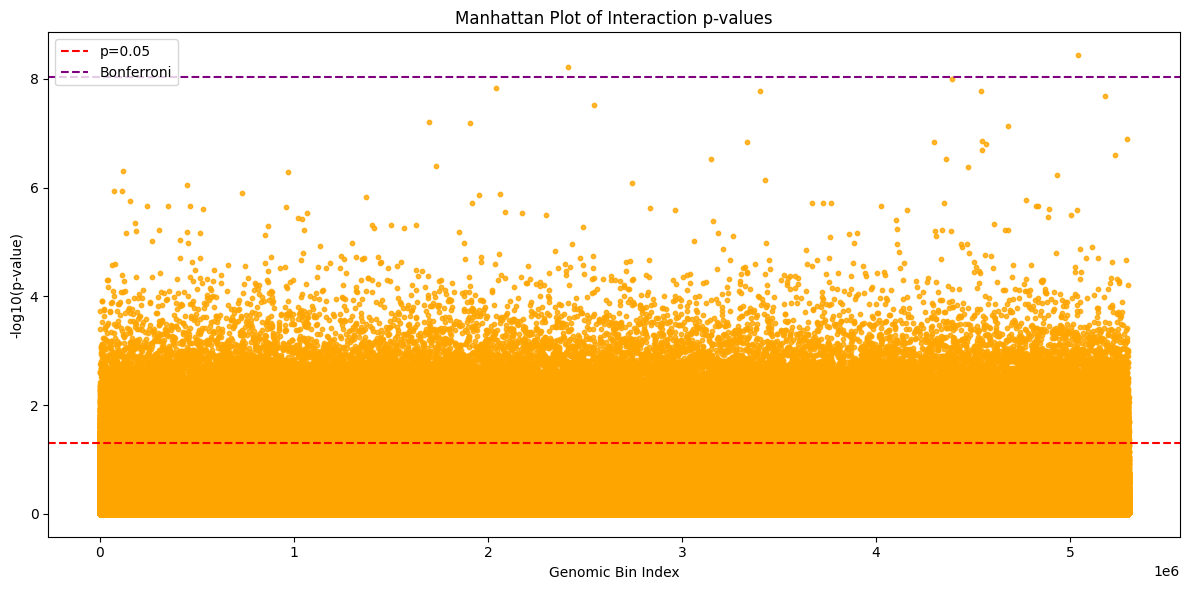

In [59]:
figures_dir = '../images/anova_results/bin1000_final' #PATH TO SAVE FIGURES 
data_dir = '../data_anova' #PATH TO SAVE CSV FILES

#Show and save visualizations
# For all bins
print("Starting general visualisations..")
#manhattan_plot(results_df, factor1_name, factor2_name, figures_dir)
manhattan_plot_seperate(results_df, factor1_name, factor2_name, figures_dir)
#volcano_plot(results_df, factor1_name, factor2_name, figures_dir)
#pvalue_distribution(results_df, factor2_name, factor2_name, figures_dir)
significance_summary(file_path, results_df, factor1_name, factor2_name, data_dir)
print("Done with general visualisations")


In [58]:
! pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


Starting specific visualisations..
Preparing top significant bins data...
Creating heatmaps of top significant bins...
Heatmaps complete. All heatmaps saved to ../images/anova_results/bin1000_final


<Figure size 3000x800 with 0 Axes>

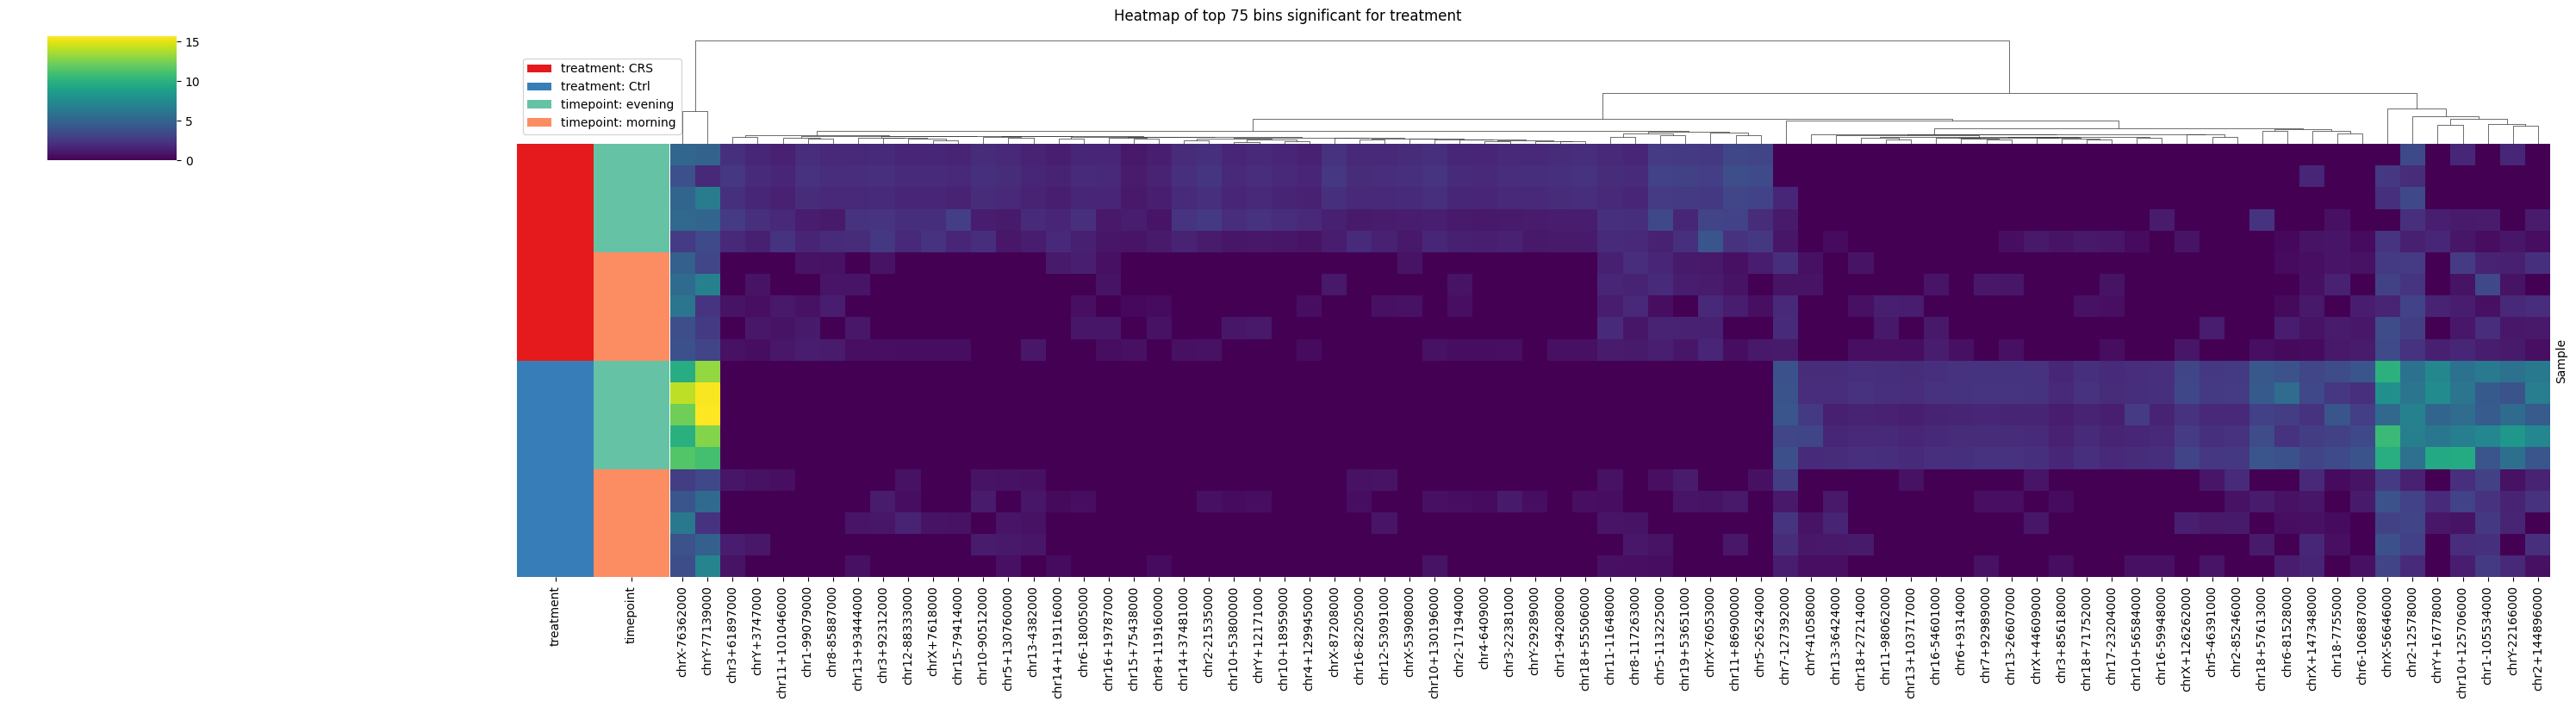

<Figure size 2640x800 with 0 Axes>

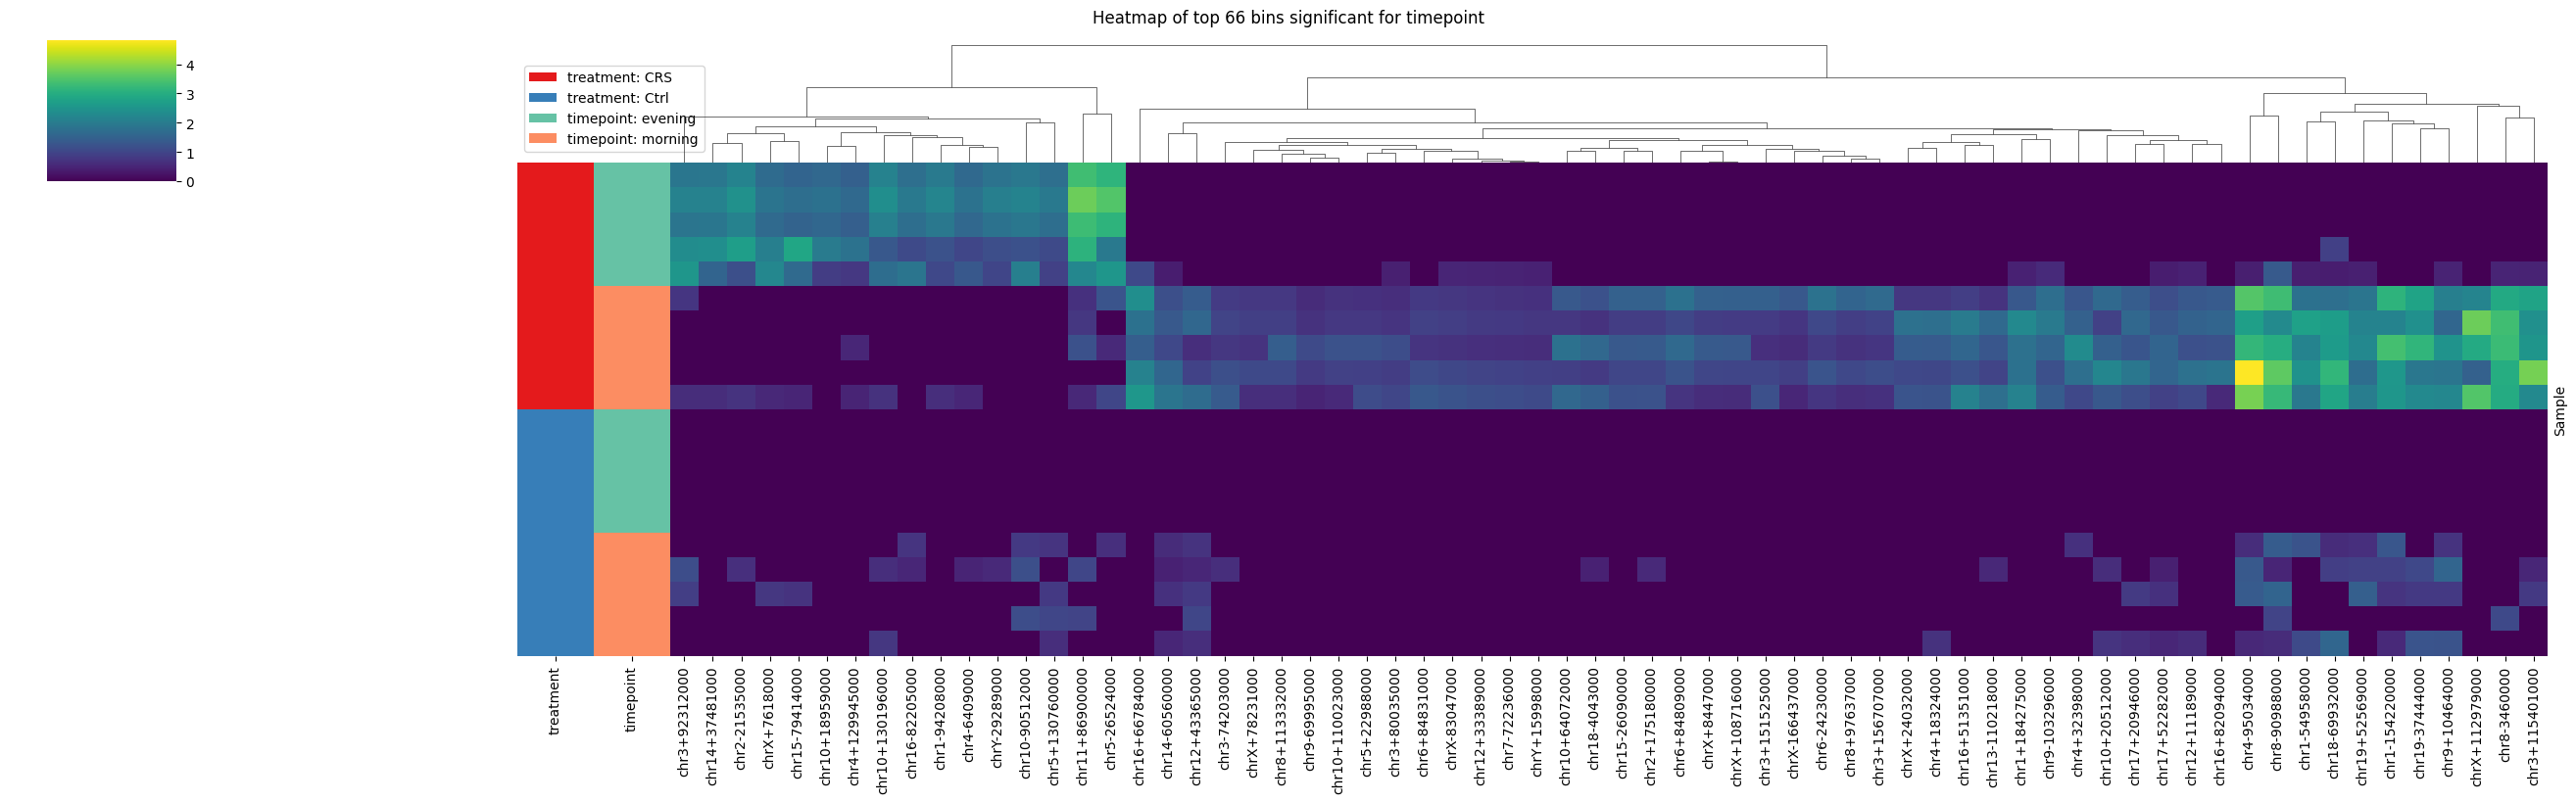

<Figure size 1000x800 with 0 Axes>

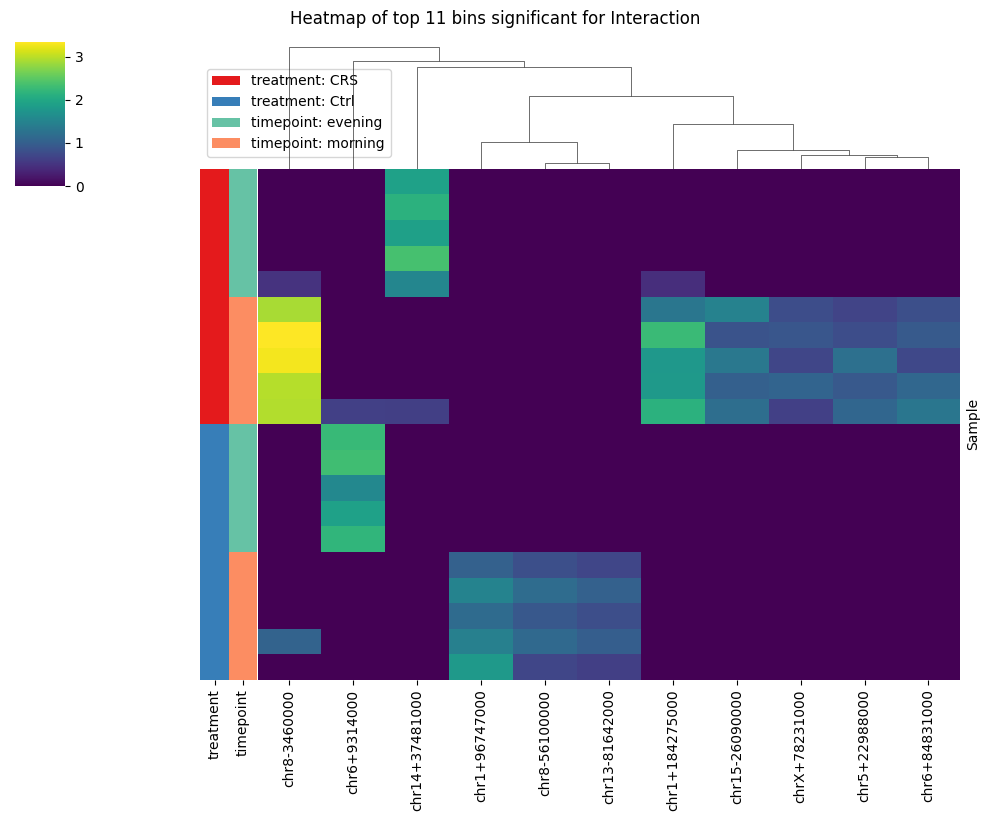

In [62]:
#For significant bins
print ("Starting specific visualisations..")
max_bins = 1000
table_path = '../data_normalized/Chromosome_naming_table_17.09.2024_Vakil.tsv' #CHANGE PATH

# Prepare the data
top_bins_dict = prepare_significant_bins_data(results_df, factor1_name, factor2_name, max_bins, file_path, table_path, data_dir)

# Generate the plots
#plot_significant_bins(pivot_df, metadata_df, top_bins_dict, factor1_name, factor2_name, figures_dir)
create_heatmap(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict, max_bins, figures_dir)